This code Segments Customers into different groups by using K-Means clustering. The different clusters will be used to analyze customers purchase sequences for the different groups on techniques like market basket analysis, popular recommendations, among other product recommendation techniques.

The inspiration for breaking customers into segments comes from the research paper:
- Rodrigues, F., & Ferreira, B. (2016). Product recommendation based on shared Customer's Behaviour. Procedia Computer Science, 100, 136-146. doi:10.1016/j.procs.2016.09.133

The following articles were used as reference for performing k-means clustering on the customer population:
- https://medium.com/@mbektas/customer-segmentation-with-clustering-algorithms-in-python-be2e021035a
- https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad

In [1]:
!pip install yellowbrick

     |████████████████████████████████| 271 kB 6.1 MB/s eta 0:00:01


In [2]:
# Loading basic needed libraries
import pandas as pd
import numpy as np
import gc
from functools import reduce
import datetime as dt
from datetime import date
from sklearn.preprocessing import StandardScaler,normalize
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from yellowbrick.cluster import KElbowVisualizer
from sklearn.decomposition import PCA

# Loading libraries for S3 bucket connection
import boto3
import io
from io import StringIO,BytesIO, TextIOWrapper
import gzip

client = boto3.client('s3') 
resource = boto3.resource('s3') 

#### Data Gathering and Preparation

In [3]:
# Reading the overall customer profile from the notebook: Customer_Behavior_Profile_Analysis.ipynb
cust_profile = pd.read_csv('s3://myaws-capstone-bucket/data/customers_of_focus.csv')
cust_profile.nunique()

user_id                     1817173
total_view                     2424
total_cart_add                  484
total_purchases                 366
total_sessions                  306
total_spent                  387698
min_spent                     39053
max_spent                     57825
cust_retailer_age               213
days_since_last_activity        213
first_view_age                  214
days_since_last_view            214
first_cart_age                  214
days_since_last_cart            214
first_purchase_age              211
days_since_last_purchase        211
dtype: int64

In [4]:
# Only keeping customers with more than 1 purchase
cust_profile = cust_profile.loc[cust_profile['total_purchases'] > 1]
cust_profile.nunique()

user_id                     914574
total_view                    2338
total_cart_add                 483
total_purchases                365
total_sessions                 284
total_spent                 383165
min_spent                    28158
max_spent                    49804
cust_retailer_age              213
days_since_last_activity       213
first_view_age                 214
days_since_last_view           214
first_cart_age                 214
days_since_last_cart           214
first_purchase_age             211
days_since_last_purchase       211
dtype: int64

In [5]:
pd.options.display.float_format = '{:.2f}'.format
cust_profile.describe()

,user_id,total_view,total_cart_add,total_purchases,total_sessions,total_spent,min_spent,max_spent,cust_retailer_age,days_since_last_activity,first_view_age,days_since_last_view,first_cart_age,days_since_last_cart,first_purchase_age,days_since_last_purchase
count,914574.00,914574.00,914574.00,914574.00,914574.00,914574.00,914574.00,914574.00,914574.00,914574.00,914574.00,914574.00,914574.00,914574.00,914574.00,914574.00
mean,563074044.70,94.83,10.38,5.25,17.63,1793.00,76.32,462.21,145.32,54.35,150.89,60.24,244.86,196.04,116.29,77.26
std,39398528.54,176.91,16.80,10.60,17.10,5234.08,179.21,416.88,58.85,54.35,241.28,242.36,1110.17,1115.54,60.53,56.07
min,128968633.00,0.00,0.00,2.00,1.00,1.17,0.00,0.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,524337123.25,18.00,3.00,2.00,7.00,353.68,0.00,169.61,103.00,7.00,103.00,7.00,75.00,21.00,71.00,29.00
50%,559125793.50,46.00,6.00,3.00,13.00,726.05,0.00,295.99,165.00,37.00,165.00,37.00,130.00,61.00,124.00,71.00
75%,594710989.25,109.00,12.00,5.00,23.00,1706.55,89.04,666.68,197.00,85.00,197.00,87.00,166.00,110.00,166.00,122.00
max,649770848.00,57349.00,2186.00,1975.00,5788.00,790098.29,2574.04,2574.07,212.00,212.00,9999.00,9999.00,9999.00,9999.00,212.00,212.00


In [6]:
# Dropping user id as it won't be used for creating the clusters - only the behavioral features will be used for cluster analysis
df_profile = cust_profile.drop('user_id',axis=1)
df_profile.head()

,total_view,total_cart_add,total_purchases,total_sessions,total_spent,min_spent,max_spent,cust_retailer_age,days_since_last_activity,first_view_age,days_since_last_view,first_cart_age,days_since_last_cart,first_purchase_age,days_since_last_purchase
2,695.00,22.00,3.00,17.00,358.79,0.00,157.02,174,0,174.00,0.00,160.00,0.00,121.00,121.00
4,66.00,8.00,2.00,4.00,81.56,0.00,41.66,128,9,128.00,9.00,128.00,16.00,128.00,16.00
7,20.00,8.00,2.00,19.00,419.58,0.00,308.86,155,50,155.00,50.00,155.00,50.00,104.00,50.00
8,165.00,9.00,2.00,35.00,575.28,0.00,312.98,174,5,174.00,5.00,131.00,123.00,123.00,123.00
13,28.00,8.00,2.00,4.00,425.23,0.00,250.97,192,101,192.00,101.00,135.00,101.00,135.00,101.00


In [7]:
# Since we have variables of multiple scales we will standardize the data before clustering
scaler = StandardScaler()
profile_scaled = scaler.fit_transform(df_profile)
# Rescailing standardize values into 0 to 1 scale
df_norm = normalize(df_profile)
df_norm = pd.DataFrame(df_norm)# converting results to df
df_norm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.80,0.03,0.00,0.02,0.41,0.00,0.18,0.20,0.00,0.20,0.00,0.18,0.00,0.14,0.14
1,0.23,0.03,0.01,0.01,0.29,0.00,0.15,0.46,0.03,0.46,0.03,0.46,0.06,0.46,0.06
2,0.03,0.01,0.00,0.03,0.69,0.00,0.51,0.26,0.08,0.26,0.08,0.26,0.08,0.17,0.08
3,0.22,0.01,0.00,0.05,0.75,0.00,0.41,0.23,0.01,0.23,0.01,0.17,0.16,0.16,0.16
4,0.04,0.01,0.00,0.01,0.68,0.00,0.40,0.31,0.16,0.31,0.16,0.21,0.16,0.21,0.16


#### Performing K-means Clustering on normalized df

In [8]:
model = KMeans()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


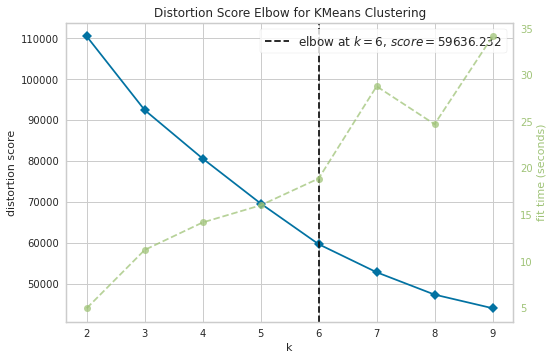

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
# Visualizing Elbow Method for K means

# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)# Concentrating on creating 2 to 10 clusters
visualizer.fit(df_norm) # Fitting the normalized data to visualizer
visualizer.show()# Displaying the Elbow plot

In [10]:
# Fitting the model for 6 clusters as mentioned by the elbow method
kmeans_fit = KMeans(n_clusters = 6, random_state = 572).fit_predict(df_norm)

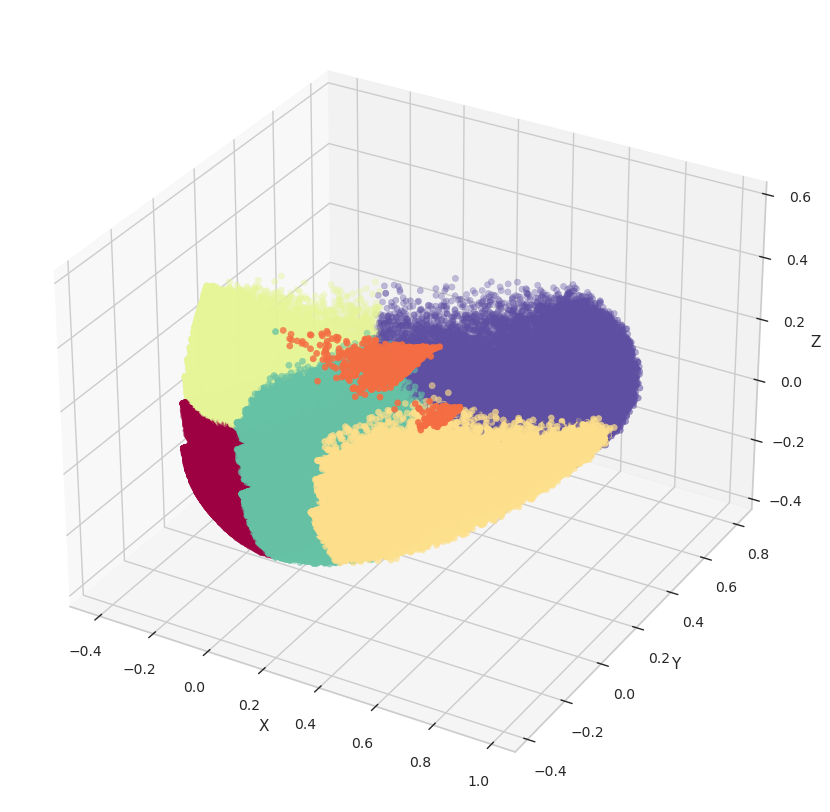

In [11]:
# Visualizing the clustered data by making used of PCA 
# As presented on article: https://medium.com/@mbektas/customer-segmentation-with-clustering-algorithms-in-python-be2e021035a

pca = PCA(n_components = 3).fit_transform(df_norm)
fig = plt.figure(figsize=(18.5, 10.5), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=kmeans_fit,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

#### Repeating Process for RFM variables

RFM Definitions
- Recency (R): Days since last purchase
- Frequency (F): Total purchases the customer has
- Monetary Value (M): Total customer spent
    
- Using the following article as reference: https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6

In [12]:
# Creating RFM DF
rfm_df = cust_profile[['user_id','days_since_last_purchase','total_purchases','total_spent']]# Keeping needed columns for RFM
rfm_df.columns = ['user_id','R','F','M']# renaming the columns
rfm_df.head()

,user_id,R,F,M
2,128968633,121.00,3.00,358.79
4,145611266,16.00,2.00,81.56
7,192078182,50.00,2.00,419.58
8,200985178,123.00,2.00,575.28
13,221480173,101.00,2.00,425.23


In [13]:
# Since we have variables of multiple scales we will standardize the data before clustering
scaler = StandardScaler()
profile_scaled = scaler.fit_transform(df_profile)
# Rescailing standardize values into 0 to 1 scale
rfm_norm = normalize(rfm_df)
rfm_norm = pd.DataFrame(rfm_norm)# converting results to df
rfm_norm.head()

,0,1,2,3
0,1.00,0.00,0.00,0.00
1,1.00,0.00,0.00,0.00
2,1.00,0.00,0.00,0.00
3,1.00,0.00,0.00,0.00
4,1.00,0.00,0.00,0.00


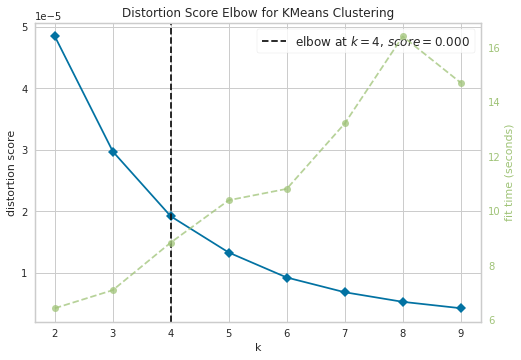

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
# Visualizing Elbow Method for K means for RFM df

# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,10), timings= True)# Concentrating on creating 2 to 10 clusters
visualizer.fit(rfm_norm) # Fitting the normalized data to visualizer
visualizer.show()# Displaying the Elbow plot

In [15]:
# Fitting the model for 4 clusters as mentioned by the elbow method
rfm_fit = KMeans(n_clusters = 4, random_state = 572).fit_predict(rfm_norm)

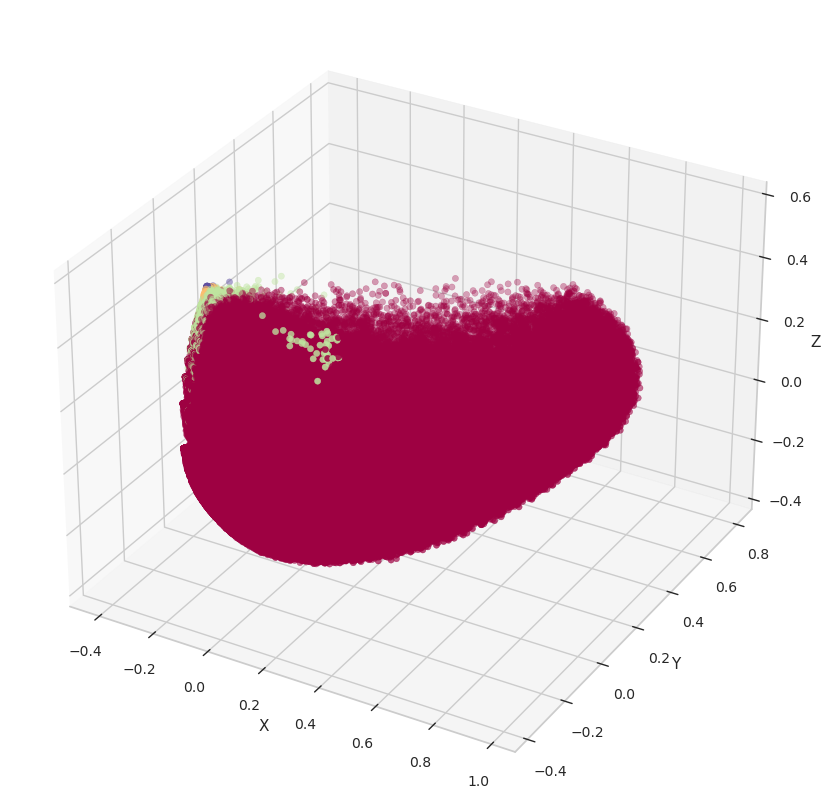

In [16]:
# Visualizing the clustered data by making used of PCA 
# As presented on article: https://medium.com/@mbektas/customer-segmentation-with-clustering-algorithms-in-python-be2e021035a

pca = PCA(n_components = 3).fit_transform(df_norm)
fig = plt.figure(figsize=(18.5, 10.5), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")
ax.scatter3D(pca.T[0],pca.T[1],pca.T[2],c=rfm_fit,cmap='Spectral')

xLabel = ax.set_xlabel('X')
yLabel = ax.set_ylabel('Y')
zLabel = ax.set_zlabel('Z')

Given that the clusters look a lot more well distributed and identified when using all the profile features vs only RFM, we will use the clustering technique will all the profile features.

#### Analyzing customers in each all profile features kmeans clusters

In [17]:
# Mapping cluster number with user id by using original cust_profile df
cust_profile['cluster'] = list(kmeans_fit)
cust_profile.head()

,user_id,total_view,total_cart_add,total_purchases,total_sessions,total_spent,min_spent,max_spent,cust_retailer_age,days_since_last_activity,first_view_age,days_since_last_view,first_cart_age,days_since_last_cart,first_purchase_age,days_since_last_purchase,cluster
2,128968633,695.00,22.00,3.00,17.00,358.79,0.00,157.02,174,0,174.00,0.00,160.00,0.00,121.00,121.00,5
4,145611266,66.00,8.00,2.00,4.00,81.56,0.00,41.66,128,9,128.00,9.00,128.00,16.00,128.00,16.00,2
7,192078182,20.00,8.00,2.00,19.00,419.58,0.00,308.86,155,50,155.00,50.00,155.00,50.00,104.00,50.00,4
8,200985178,165.00,9.00,2.00,35.00,575.28,0.00,312.98,174,5,174.00,5.00,131.00,123.00,123.00,123.00,4
13,221480173,28.00,8.00,2.00,4.00,425.23,0.00,250.97,192,101,192.00,101.00,135.00,101.00,135.00,101.00,4


In [19]:
# Savings Results to S3
cust_profile.to_csv('s3://myaws-capstone-bucket/data/full_profile_segments.csv',index=False)

In [20]:
#### Analyzing customers in each all profile features kmeans clusters
customers=pd.DataFrame(cust_profile['cluster'].value_counts()).rename(columns={'Clusters':'Number of Customers'})
customers.T

,3,0,4,2,5,1
cluster,260351,249827,224798,104113,63822,11663


In [21]:
260351 + 249827 + 224798 + 104113 + 63822 + 11663

914574

In [22]:
# Analyzing RFM behavior of each cluster 
# where R,F,M values are given by the columns - 'days_since_last_purchase','total_purchases','total_spent'
cust_profile.groupby('cluster').agg(
{
    'days_since_last_purchase':['mean','min','max'],
    'total_purchases':['mean','min','max'],
    'total_spent':['mean','min','max']
})

days_since_last_purchase             total_purchases               \
                            mean  min    max            mean  min     max   
cluster                                                                     
0                          63.12 0.00 212.00            2.79 2.00   42.00   
1                         177.10 1.00 212.00            2.56 2.00   28.00   
2                         116.61 0.00 212.00            2.37 2.00   26.00   
3                          64.05 0.00 212.00           11.37 3.00 1975.00   
4                          92.44 0.00 212.00            2.95 2.00   35.00   
5                          50.55 0.00 212.00            3.23 2.00   64.00   

        total_spent                  
               mean   min       max  
cluster                              
0           1208.84 10.32   7721.37  
1            827.28  2.00  13682.97  
2            192.65  1.70   3322.60  
3           4528.22 44.87 790098.29  
4            503.83  8.99  14564.67  
5            249.79  1.17   5306.56

In [23]:
cluster_segments = cust_profile[['user_id','cluster']]
cluster_segments.head()

,user_id,cluster
2,128968633,5
4,145611266,2
7,192078182,4
8,200985178,4
13,221480173,4


In [24]:
cluster_segments.nunique()

user_id    914574
cluster         6
dtype: int64

In [25]:
# Savings Results to S3
cluster_segments.to_csv('s3://myaws-capstone-bucket/data/cluster_segments.csv',index=False)